# sudire.py example notebook

The aim of this notebook is to show how to perform  Sufficient Dimension Reduction  using the direpack package. The data we will use  is the [auto-mpg dataset](http://archive.ics.uci.edu/ml/datasets/Auto+MPG). We wil show how the dimension of the central subspace and a basis for the central subspace can be estimated using Sufficient Dimension Reduction via Ball covariance and by using a user defined function.    

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy import stats
from direpack.sudire.sudire import sudire,estimate_structural_dim
from direpack.plot.sudire_plot import sudire_plot
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'cyipopt'

In [2]:
plt.rcParams["figure.figsize"] = [16,13]
plt.rcParams['figure.constrained_layout.use'] = True
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

## Data preprocessing

In [3]:
auto_data = pd.read_csv('../data/auto-mpg.csv', index_col='car_name')
display(auto_data.head())
print('dataset shape is',auto_data.shape)
print(auto_data.dtypes)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
car_name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,1
buick skylark 320,15.0,8,350.0,165,3693,11.5,70,1
plymouth satellite,18.0,8,318.0,150,3436,11.0,70,1
amc rebel sst,16.0,8,304.0,150,3433,12.0,70,1
ford torino,17.0,8,302.0,140,3449,10.5,70,1


dataset shape is (398, 8)
mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight            int64
acceleration    float64
model year        int64
origin            int64
dtype: object


 Looking at the data, we see that the horsepower variable should be a numeric variable but is displayed as type object. This is because missing values are coded as '?'. We thus remove those missing values.  After this step, there are no more missing values into the data. 

In [4]:
auto_data = auto_data[auto_data.horsepower != '?']
auto_data.horsepower = auto_data.horsepower.astype('float')
print('data types \n', auto_data.dtypes)
print('any missing values \n',auto_data.isnull().any())

data types 
 mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight            int64
acceleration    float64
model year        int64
origin            int64
dtype: object
any missing values 
 mpg             False
cylinders       False
displacement    False
horsepower      False
weight          False
acceleration    False
model year      False
origin          False
dtype: bool


In [5]:
X = auto_data.copy()
y = X['mpg']
X.drop('mpg', axis=1, inplace=True)
X.drop('origin', axis = 1, inplace = True)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.3, random_state=42)

# Estimating a basis of the central subspace

First let us suppose that we know the dimension of the central subspace to be 2. We will then see how to estimate a basis for the central subspaces using the various options.

In [7]:
struct_dim = 2

# via distance covariance

In [8]:
dcov_auto = sudire('dcov-sdr', center_data= True, scale_data=True,n_components=struct_dim)
dcov_auto.fit(X_train.values, y_train.values)
dcov_auto.x_loadings_

array([[-1.41351635e-01,  1.17262790e+00],
       [-1.84653356e-03,  1.56519690e-03],
       [ 2.51523300e-03, -6.62819602e-03],
       [-6.37155448e-04, -1.74767493e-03],
       [ 4.35380762e-03,  3.23740457e-02],
       [ 7.73805975e-02,  1.84751807e-01]])

## via Martingale Difference Divergence

In [9]:
mdd_auto = sudire('mdd-sdr', center_data= True, scale_data=True,n_components=struct_dim)
mdd_auto.fit(X_train.values, y_train.values)
mdd_auto.x_loadings_

array([[ 0.21565348, -0.11753519],
       [ 0.00129979,  0.02526417],
       [-0.00117185, -0.05326589],
       [ 0.00049391, -0.00060562],
       [-0.01315811, -0.00581819],
       [-0.07225742,  0.02673651]])

## User defined functions

Here we show how user can optimize their own functions as is done for Distance Covariance and Martingale Difference Divergence.
For this example we will use Ball covariance. There is a python package : [Ball](https://pypi.org/project/Ball/) available on PyPi which computes the Ball covariance between random variables. We follow the development of the article [Robust sufficient Dimension Reduction Via Ball covariance](https://www.sciencedirect.com/science/article/pii/S0167947319301380). The process is similar to using scipy.optimize.minimize function. 

In [10]:
import Ball

First we define the objective function to be optimized. Here,  beta is the flattened array representing the basis of the central subpace. A series of arguments can be passed to this function, including the X and y data as well as the dimension of the central subspace. 

In [11]:
def ballcov_func(beta, *args):
    X= args[0]
    Y= args[1]
    h=args[2]
    beta = np.reshape(beta,(-1,h),order = 'F')
    X_dat = np.matmul(X, beta)
    res = Ball.bcov_test(X_dat,Y,num_permutations=0)[0] 
    return(-10*res)


Next we define the contraints and additional optimization arguments.  both the constraints and arguments are assumed to be dicts or tuples. 

In [12]:
def optim_const(beta, *args):
    X= args[0]
    h= args[1]
    i = args[2]
    j = args[3]
    beta = np.reshape(beta,(-1,h),order = 'F')
    covx = np.cov(X, rowvar=False)
    ans = np.matmul(np.matmul(beta.T,covx), beta) - np.identity(h)
    return(ans[i,j])

ball_const= []
for i in range(0, struct_dim):  
    for j in range(0,struct_dim): 
        ball_const.append({'type': 'eq', 'fun' : optim_const,
                      'args':(X_train,struct_dim,i,j)})
        
ball_const =tuple(ball_const)

optim_args = (X_train,y_train, struct_dim)

In [13]:
bcov_auto = sudire(ballcov_func, center_data= True, scale_data=True,n_components=struct_dim)
bcov_auto.fit(X_train.values, y_train.values)
bcov_auto.x_loadings_

array([[ 6.24512038e-01, -1.86477855e+00],
       [-1.23653471e-02,  2.63759104e-02],
       [-1.59710662e-02, -1.30689927e-02],
       [ 4.67160270e-04,  6.09643088e-04],
       [-3.22741068e-02, -8.46558637e-02],
       [-2.94149178e-01, -1.11379712e-01]])

## Estimating the dimension of the central subspace

The dimension of the central subspace can be estimated using the bootstrap method proposed in [Sufficient Dimension Reduction via Distance Covariance](https://www.tandfonline.com/doi/abs/10.1080/10618600.2015.1026601). All the implemented sdr methods can be used. Here we present the method using Directional Regression.

In [14]:
central_dim, diff_vec = estimate_structural_dim('dr',X_train.values, y_train.values, B=100, n_slices=4)

central_dim

possible dim 1
possible dim 2
possible dim 3
possible dim 4
possible dim 5
possible dim 6


6

## Plots

Once the sufficient Dimension Reduction has been done, an OLS regression is fitted using the reduced subset of variables. we can visualise the predicted response values using the plot functions from sudire_plots.

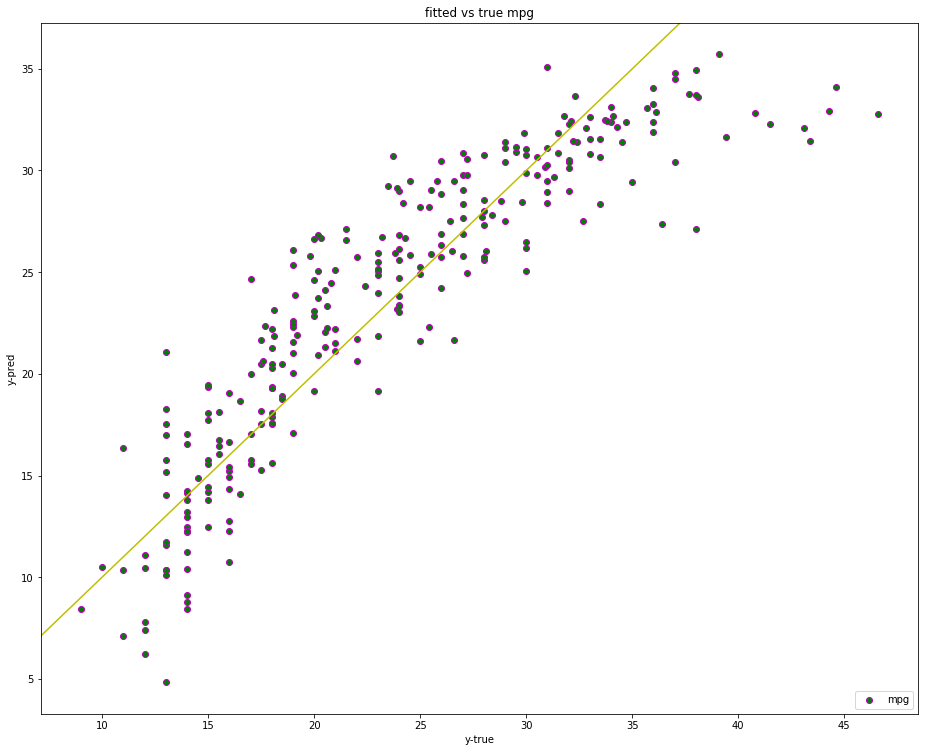

In [15]:
sdr_plot=sudire_plot(dcov_auto,['w','w','g','y','m'])
sdr_plot.plot_yyp(label='mpg',title='fitted vs true mpg')

The projections of the data can also be visualised

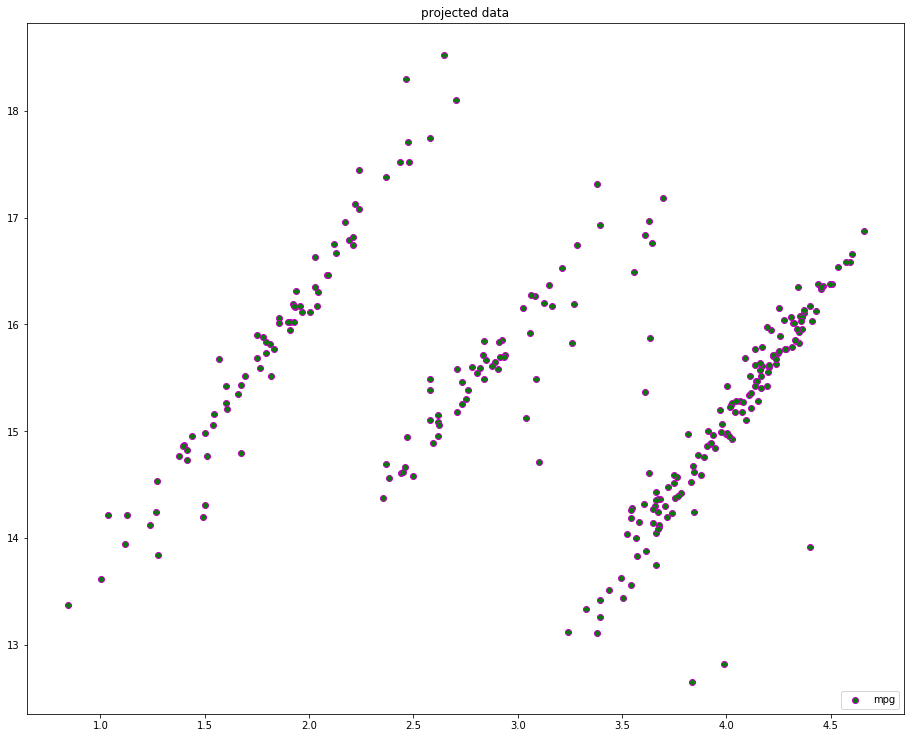

In [16]:
sdr_plot=sudire_plot(dcov_auto,['w','w','g','y','m'])
sdr_plot.plot_projections(label='mpg', title='projected data')